<a href="https://colab.research.google.com/github/lee021/2024-spark/blob/main/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, year, datediff, expr, lit, when, sum, udf
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark.sql.functions import to_date

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [ ]:
# CSV 파일 읽기 (UTF-8 인코딩 지정)
Df_04 = spark.read.csv('weather_data/04.CSV', header=True, sep=",",  encoding='CP949')
Df_05 = spark.read.csv('weather_data/05.CSV', header=True, sep=",",  encoding='CP949')
Df_06 = spark.read.csv('weather_data/06.CSV', header=True, sep=",",  encoding='CP949')
Df_07 = spark.read.csv('weather_data/07.CSV', header=True, sep=",",  encoding='CP949')
Df_08 = spark.read.csv('weather_data/08.CSV', header=True, sep=",",  encoding='CP949')
Df_09 = spark.read.csv('weather_data/09.CSV', header=True, sep=",",  encoding='CP949')

Df_List = [Df_04, Df_05, Df_06, Df_07, Df_08, Df_09]
new_Df_List = []

# 새 열 이름 정의
new_columns = {
    '일시': 'date',
    '최고기온(°C)': 'max_temperature',
    '평균상대습도(%)': 'relative_humidity',
    '자외선지수(단계)': 'UV'
}

# 각 DataFrame에 열 이름 변경 및 정렬 적용
for i, df in enumerate(Df_List):
    for old_name, new_name in new_columns.items():
        df = df.withColumnRenamed(old_name, new_name)
    df = df.orderBy('date')
    Df_List[i] = df  # 변경된 DataFrame을 리스트에 다시 저장

# 변경된 Df_List 각각 변수에 저장 (언패킹)
Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List


# '일시' 열을 기준으로 agg
for df in Df_List:
  new_df = df.groupBy('date').agg(
      avg('max_temperature').alias('average_max_temperature'),
      avg('relative_humidity').alias('average_relative_humidity')
  )
  new_Df_List.append(new_df)

# 언패킹
new_Df_04, new_Df_05, new_Df_06, new_Df_07, new_Df_08, new_Df_09 = new_Df_List


# UDF 정의
def uv_index_to_numeric(uv_index):
    mapping = {
        "낮음": 1.5,
        "보통": 4.5,
        "높음": 7,
        "매우높음": 9.5,
        "위험" : 13.0
    }
    return mapping.get(uv_index, 0)

# UDF 등록
uv_index_to_numeric_udf = udf(uv_index_to_numeric, DoubleType())

# UDF 적용
for i, df in enumerate(Df_List):
  Df_List[i] = df.withColumn("UV", uv_index_to_numeric_udf(col("UV")))
  Df_List[i] = Df_List[i].groupBy('date').agg(
    avg('UV').alias('average_UV')
).orderBy('date')

# 변경된 Df_List 각각 변수에 저장 (언패킹)
Df_04, Df_05, Df_06, Df_07, Df_08, Df_09 = Df_List



# 최종 join
merged_List = []

for i, df in enumerate(Df_List):
  merged_df = new_Df_List[i].join(df, 'date')
  merged_List.append(merged_df)

# 언패킹
df_merged_04, df_merged_05, df_merged_06, df_merged_07, df_merged_08, df_merged_09 = merged_List



# DataFrame 합치기
combined_df = df_merged_04.union(df_merged_05).union(df_merged_06)\
.union(df_merged_07).union(df_merged_08).union(df_merged_09)


combined_df.show(500)


+----------+-----------------------+-------------------------+------------------+
|      date|average_max_temperature|average_relative_humidity|        average_UV|
+----------+-----------------------+-------------------------+------------------+
|2023-04-01|     24.083333333333332|        49.09687500000001|               4.5|
|2023-04-02|     22.516666666666676|                44.174375|              NULL|
|2023-04-03|     23.025925925925918|        44.16125000000001|               9.5|
|2023-04-04|     21.048148148148137|       58.641250000000014|               4.5|
|2023-04-05|      16.07839506172839|                90.984375|               1.5|
|2023-04-06|     12.537654320987647|        85.67187500000001|               4.5|
|2023-04-07|     16.011180124223607|        62.63481012658227| 4.884615384615385|
|2023-04-08|     15.277018633540372|        48.57106918238995|               9.5|
|2023-04-09|     18.766459627329205|        51.61139240506329|               9.5|
|2023-04-10|    

**분석과제 [이태용]**

**자외선지수와 온도, 습도와의 상관관계 분석**

문제설명:

1. 일별로 평균최고온도, 평균상대습도, 평균자외선 지수를 구한다. [바로 아래 예시 참고]



> ※ 자외선지수는 기상정보에 따라 다음과 같이 수치화한다.

> "낮음": 1.5,  "보통": 4.5,  "높음": 7,     "매우높음": 9.5, "위험": 13




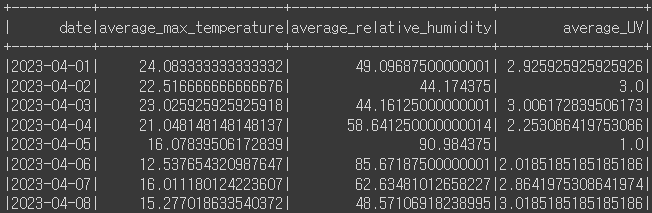

2. average_max_temperature의 평균 값보다 높은 행들 필터링, 낮은 행들 각각 필터링

3. 필터링된 두 dataframe의 average_UV값을 비교 => 온도파트 끝

4. average_relative_humidity의 평균 값보다 높은 행들 필터링, 낮은 행들 필터링

5. 필터링된 두 dataframe의 average_UV값을 비교 => 습도파트 끝


출력 결과 예시 :

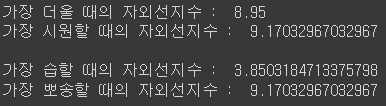

In [ ]:
# average_max_temperature의 평균 값 계산
avg_max_temp = combined_df.select(avg('average_max_temperature')).collect()[0][0]

# 평균보다 높은 행 필터링
high_temp = combined_df.filter(combined_df['average_max_temperature'] > avg_max_temp)

# 평균보다 낮은 행 필터링
low_temp = combined_df.filter(combined_df['average_max_temperature'] <= avg_max_temp)

# 결과 출력 (선택)
# high_temp.show()
# low_temp.show()

high_temp_UV = high_temp.select('average_UV').collect()[0][0]
low_temp_UV = low_temp.select('average_UV').collect()[0][0]

# 최종 결과 도출
print("가장 더울 때의 자외선지수 : ",high_temp_UV)
print("가장 시원할 때의 자외선지수 : ",low_temp_UV)




# average_max_temperature의 평균 값 계산
avg_relative_humidity = combined_df.select(avg('average_relative_humidity')).collect()[0][0]

# 평균보다 높은 행 필터링
high_hum = combined_df.filter(combined_df['average_relative_humidity'] > avg_relative_humidity)

# 평균보다 낮은 행 필터링
low_hum = combined_df.filter(combined_df['average_relative_humidity'] <= avg_relative_humidity)

# 결과 출력 (선택)
# high_hum.show(100)
# low_hum.show(100)

high_hum_UV = high_hum.select('average_UV').collect()[0][0]
low_hum_UV = low_hum.select('average_UV').collect()[0][0]

# 최종 결과 도출
print("\n가장 습할 때의 자외선지수 : ",high_hum_UV)
print("가장 뽀송할 때의 자외선지수 : ",low_hum_UV)




가장 더울 때의 자외선지수 :  8.95
가장 시원할 때의 자외선지수 :  9.17032967032967

가장 습할 때의 자외선지수 :  3.8503184713375798
가장 뽀송할 때의 자외선지수 :  9.17032967032967
